# Load data

In [16]:
import numpy as np
import scipy.io
import pandas as pd

m1_imported = scipy.io.loadmat('/home/klab/Public/Stevenson_50ms.mat')
data = pd.DataFrame()
data['time'] =  m1_imported['time'][:,0]
data['handPos_x'] =  m1_imported['handPos'][:,0]
data['handPos_y'] =  m1_imported['handPos'][:,1]
data['handVel_x'] =  m1_imported['handVel'][:,0]
data['handVel_y'] =  m1_imported['handVel'][:,1]

X = m1_imported['spikes']
Y = m1_imported['handVel']

testSamples  = range(0,1554)
trainSamples = range(1554, 15665)   

X_test = X[testSamples, :]
Y_test = Y[testSamples, :]
# print(X_test.shape,Y_test.shape)
X_train = X[trainSamples, :]
Y_train = Y[trainSamples, :]
# print(X_train.shape,Y_train.shape)

# Run XGBOOST

In [17]:
from copy import copy, deepcopy
from RE_PartialRecData import RE_PartialRecData
from RE_PartialRecData2 import RE_PartialRecData2
import os
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier
import pickle
from sklearn import preprocessing

params = {}
# use softmax multi-class classification 'multi:softmax'
# use linear regression 'reg:linear'
params['objective'] = 'reg:linear'

# scale weight of positive examples
params['eta'] = 0.5               # Makes the model more robust by shrinking the weights on each step (0.01-0.2)
params['max_depth'] = 6           # Used to control over-fitting as higher depth will allow model to learn relations 
                                  # very specific to a particular sample. (3-10)
params['silent'] = 1
params['nthread'] = 4
# params['num_class'] = np.max(X_train)
num_round = 5

nRecordings = 10
nIterations = 5
nOutNeurons = 2

subnetSize = [2**x for x in range(8)]
subnetSize.append(172)
nSubnetSize = len(subnetSize)

nSamples = np.divide(int(X_train.shape[0]/nRecordings),subnetSize)*100
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])

for ss in range(nSubnetSize):
    print(subnetSize[ss])
    for it in range(nIterations):
        nLayerNeurons = subnetSize[ss]
        X_subsample, Y_subsample = RE_PartialRecData2(X_train, Y_train, 
                                                              nLayerNeurons, nRecordings, nSamples[ss])

        # impute X_subsample with mean value, apply imputation to test set
        imp = preprocessing.Imputer(missing_values='NaN', strategy='mean')
        impf = imp.fit(X_subsample)
        X_new = impf.transform(X_subsample)
        X_test_new = impf.transform(X_test)

        for iN in range(nOutNeurons):
            #print('#neuron, #iteratin, subnetsize: ', iN,it,subnetSize[ss])
            xg_train  = xgb.DMatrix(X_new, label=Y_subsample[:, iN])
            xg_test   = xgb.DMatrix(X_test_new, label=Y_test[:, iN])
            watchlist = [(xg_train, 'train'), (xg_test, 'test')]
            # train XGboost
            bst = xgb.train(params, xg_train, num_round, watchlist, verbose_eval=False)
            # get predictions
            pred = bst.predict(xg_test)
            rmses[it, iN, ss] = np.sqrt(np.mean((bst.predict(xg_test)-Y_test[:, iN])**2))
            
        print ('predicting, mean RMSEs=%f' %np.mean(rmses[it, :, ss]))

fName = 'results/XGB_MVI_RMSES_nRec' + str(nRecordings) + '_Spiking.dat'
# save the rmse's
with open(fName,'wb') as f:
    pickle.dump(rmses, f)
f.close()

1
predicting, mean RMSEs=0.061771
predicting, mean RMSEs=0.061061
predicting, mean RMSEs=0.061012
predicting, mean RMSEs=0.060899
predicting, mean RMSEs=0.061957
2
predicting, mean RMSEs=0.059434
predicting, mean RMSEs=0.061907
predicting, mean RMSEs=0.060865
predicting, mean RMSEs=0.061454
predicting, mean RMSEs=0.057526
4
predicting, mean RMSEs=0.060713
predicting, mean RMSEs=0.060965
predicting, mean RMSEs=0.061151
predicting, mean RMSEs=0.058885
predicting, mean RMSEs=0.060318
8
predicting, mean RMSEs=0.058675
predicting, mean RMSEs=0.060194
predicting, mean RMSEs=0.059697
predicting, mean RMSEs=0.058969
predicting, mean RMSEs=0.057051
16
predicting, mean RMSEs=0.058237
predicting, mean RMSEs=0.057314
predicting, mean RMSEs=0.057564
predicting, mean RMSEs=0.058321
predicting, mean RMSEs=0.056968
32
predicting, mean RMSEs=0.061580
predicting, mean RMSEs=0.057247
predicting, mean RMSEs=0.058536
predicting, mean RMSEs=0.057473
predicting, mean RMSEs=0.060341
64
predicting, mean RMSEs=

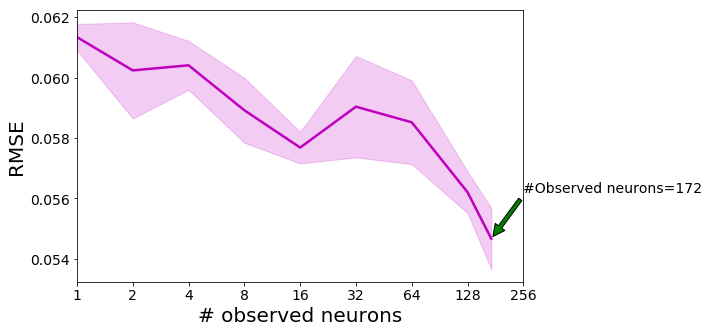

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [2**x for x in range(8)]
x.append(172)
xx = range(len(x))
y = np.mean(np.mean(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)

figName = '../partial_recordings/figures/XGBMVI_RMSEs_Spiking'
fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .35, wspace=.15)
ax1.plot(x, y, linewidth=2.5, color='m')
plt.fill_between(x, y-error, y+error, alpha=0.2, color='m')

ax1.annotate('#Observed neurons=172', xy=(x[-1], y[-1]), xytext=(256, y[-2]),\
             fontsize=14, arrowprops=dict(facecolor='g', shrink=0.05))

ax1.set_xscale('log', basex=2)
ax1.set_xlabel('# observed neurons', fontsize=20)
ax1.set_xlim([1,2**8])
ax1.set_xticks([2**x for x in range(9)])
ax1.set_xticklabels( [2**x for x in range(9)], fontsize=14)
ax1.set_ylabel('RMSE', fontsize=20)
ylim = ax1.get_ylim()
ax1.set_ylim(ylim)
ax1.tick_params('both', labelsize=14)

plt.draw()
plt.savefig(figName +'.pdf', format='pdf')
plt.savefig(figName +'.eps', format='eps', dpi=1000)